# WHO Suicide Statistics
https://www.kaggle.com/szamil/who-suicide-statistics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

## Exploratory data analysis.

In [2]:
data = pd.read_csv('data/who_suicide_statistics.csv')

In [3]:
data.head().T

,0,1,2,3,4
country,Albania,Albania,Albania,Albania,Albania
year,1985,1985,1985,1985,1985
sex,female,female,female,female,female
age,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years
suicides_no,NaN,NaN,NaN,NaN,NaN
population,277900,246800,267500,298300,138700


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 6 columns):
country        43776 non-null object
year           43776 non-null int64
sex            43776 non-null object
age            43776 non-null object
suicides_no    41520 non-null float64
population     38316 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB


In [5]:
data.describe()

,year,suicides_no,population
count,43776.000000,41520.000000,3.831600e+04
mean,1998.502467,193.315390,1.664091e+06
std,10.338711,800.589926,3.647231e+06
min,1979.000000,0.000000,2.590000e+02
25%,1990.000000,1.000000,8.511275e+04
50%,1999.000000,14.000000,3.806550e+05
75%,2007.000000,91.000000,1.305698e+06
max,2016.000000,22338.000000,4.380521e+07


In [6]:
data.isna().sum()

country           0
year              0
sex               0
age               0
suicides_no    2256
population     5460
dtype: int64

In [7]:
## Removing lines without suicides_no or population
data = data.dropna(subset=['suicides_no', 'population'])
data.to_csv('data/data.csv', index=False)

## # of Suicides per year

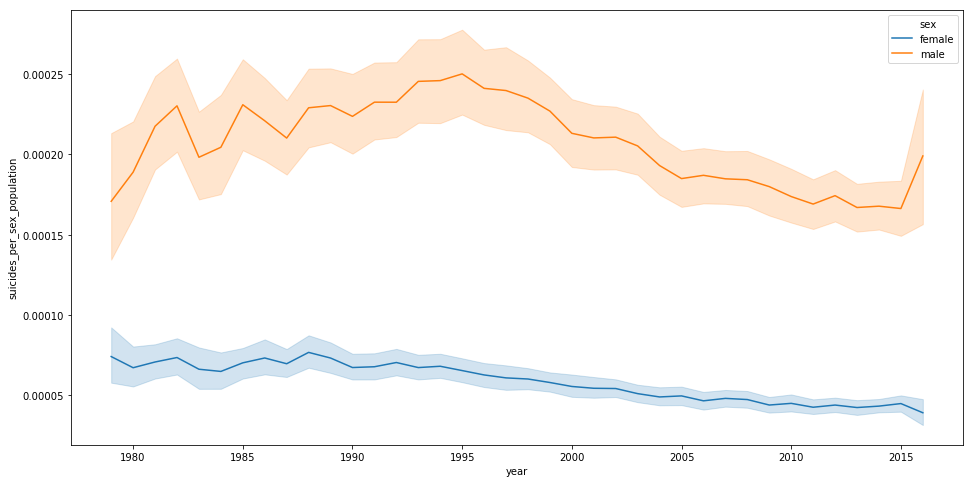

In [8]:
data['suicides_per_sex_population'] = data['suicides_no'] / data['population']
plt.figure(figsize=(16, 8))
plt.title = 'Suicides per sex per year'
sns.lineplot(x="year", y="suicides_per_sex_population", hue="sex", data=data)

### Suicides per age group

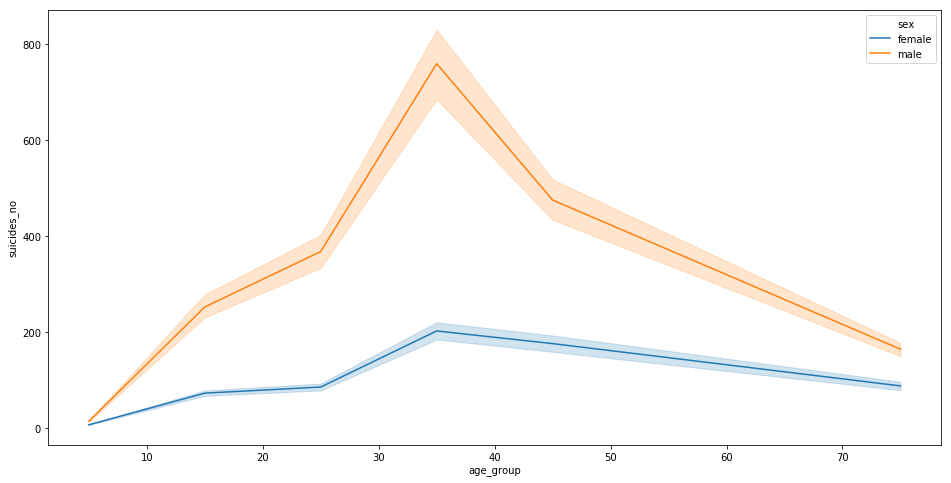

In [9]:
groups_map = {
    "5-14 years": 5,
    "15-24 years": 15,
    "25-34 years": 25,
    "35-54 years": 35,
    "55-74 years": 45,
    "75+ years": 75,
}
data["age_group"] = data['age'].map(groups_map)
plt.figure(figsize=(16, 8))
sns.lineplot(x="age_group", y="suicides_no", hue="sex", data=data)

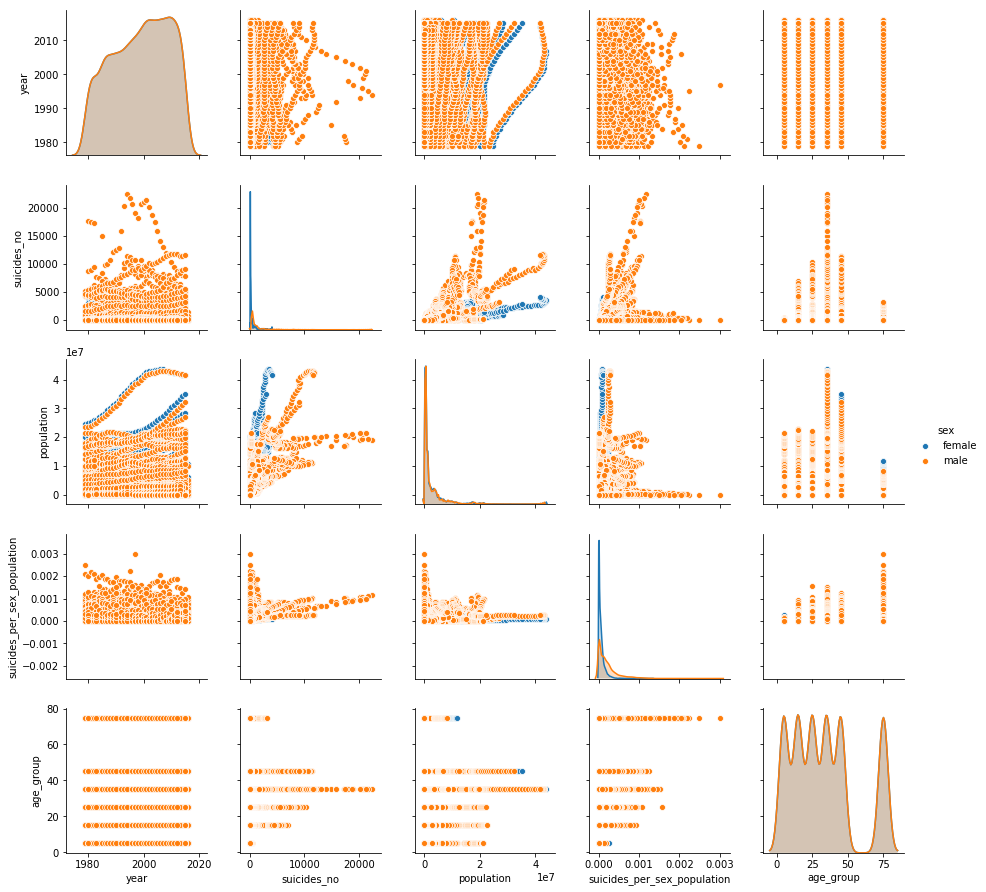

In [10]:
sns.pairplot(data, hue='sex')

## Feature preprocessing

In [7]:
def preprocess(data):
    data = encode_countries(data)
    data = encode_age(data)
    data = encode_sex(data)
    return data
    
def encode_countries(data):
    country_encoder = LabelEncoder()
    country_encoder.fit(data['country'])
    data['country'] = country_encoder.transform(data['country'])
    return data

def encode_age(data):
    groups_map = {
        "5-14 years": 5,
        "15-24 years": 15,
        "25-34 years": 25,
        "35-54 years": 35,
        "55-74 years": 45,
        "75+ years": 75,
    }
    data["age"] = data['age'].map(groups_map)
    return data
    
def encode_sex(data):
    data = pd.concat([data, pd.get_dummies(data['sex'])], axis=1)
    data = data.drop(['sex'], axis=1)
    return data

### Split data

In [8]:
def split(data):
    target = 'suicides_no'
    feature_columns = data.columns.to_list()
    feature_columns.remove(target)
    
    train_data, test_data, train_targets, test_targets = train_test_split(
        data[feature_columns], 
        data[target], 
        test_size=0.2,
        shuffle=True,
    )
    return train_data, test_data, train_targets, test_targets

## RandomForestRegressor

In [14]:
data = pd.read_csv('data/data.csv')
data = preprocess(data)

In [15]:
train_data, test_data, train_targets, test_targets = split(data)

In [16]:
regresor_gs = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        "n_estimators": np.linspace(5, 100, 4).astype(int),
        "min_samples_leaf": np.linspace(1, 100, 3).astype(int),
        "max_depth": np.linspace(10, 100, 3).astype(int),
        "max_features": ['sqrt', 'log2', 0.1],
    },
    n_jobs=-1,
    cv=4,
    verbose=1,
)

In [17]:
regresor_gs.fit(train_data, train_targets)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.6min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([  5,  36,  68, 100]), 'min_samples_leaf': array([  1,  50, 100]), 'max_depth': array([ 10,  55, 100]), 'max_features': ['sqrt', 'log2', 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [18]:
regresor_gs.best_score_

0.9742607253522887

In [19]:
random_forest_model = regresor_gs.best_estimator_
joblib.dump(random_forest_model, 'random_forest_model.pkl')
random_forest_model = joblib.load('random_forest_model.pkl')

## Evaluation

In [24]:
def print_score(preds, targets):
    mse = mean_squared_error(preds, targets)
    print(f"Mean squered error {mse}")

    rmse = np.sqrt(mse)
    print(f"RMSE {rmse}")
    
def plot_predictions(preds, targets):
    fig,ax = plt.subplots()
    ax.scatter(targets, preds)
    ax.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    fig.show()

Mean squered error 9894.50093264158
RMSE 99.47110601899217


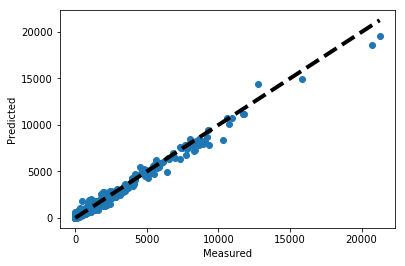

In [21]:
print_score(random_forest_model.predict(test_data), test_targets)
plot_predictions(random_forest_model.predict(test_data), test_targets)

# Deep learning model

In [4]:
!pip install -q tensorflow==2.0.0-beta1

In [5]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

### Data preprocessing

In [9]:
data = pd.read_csv('data/data.csv')
data = preprocess(data)

In [10]:
target = 'suicides_no'
feature_columns = data.columns.to_list()
feature_columns.remove(target)

In [11]:
train_data, test_data, train_targets, test_targets = split(data)

In [12]:
train_stats = data.describe()
train_stats.pop("suicides_no")
train_stats = train_stats.T

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

train_data = norm(train_data)
test_data = norm(test_data)

In [13]:
def make_model(input_shape, layer_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layer_size, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), 
        loss=tf.keras.losses.mean_squared_error, 
        metrics=[
            tf.keras.metrics.mean_squared_error,
            tf.keras.metrics.mae
        ]
    )
    return model

In [14]:
model = make_model(input_shape=[len(feature_columns)], layer_size=32)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1

In [16]:
EPOCHS=1000
VAL_SPLIT=0.2

In [17]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
        if epoch == EPOCHS-1:
            print('')
            print('Done')

In [18]:
history = model.fit(
    train_data,
    train_targets, 
    epochs=EPOCHS,
    validation_split=VAL_SPLIT,
    verbose=0,
    callbacks=[PrintDot()],
    batch_size=512,
    shuffle=True
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [19]:
model.save('model.h5')
model = tf.keras.models.load_model('model.h5')

### Learning history

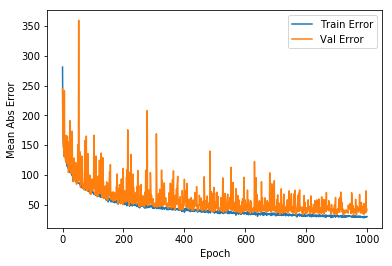

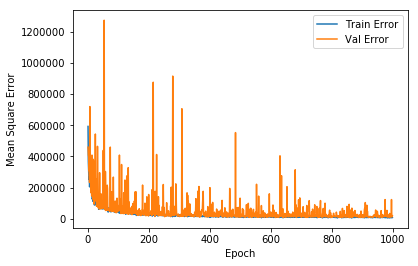

In [62]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    plt.show()


plot_history(history)

## Predictions

In [25]:
test_preds = model.predict(test_data)

### RMSE score

In [26]:
print_score(test_preds, test_targets)

Mean squered error 13448.245503796756
RMSE 115.96657063049142


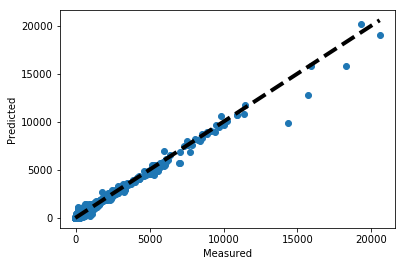

In [27]:
plot_predictions(test_targets, test_preds)

In [54]:
### Using EarlyStopping to reduce overfit

In [28]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_data, 
    train_targets,
    epochs=EPOCHS,
    validation_split = VAL_SPLIT, 
    verbose=0, 
    callbacks=[early_stop, PrintDot()],
    batch_size=512,
    shuffle=True
)


................

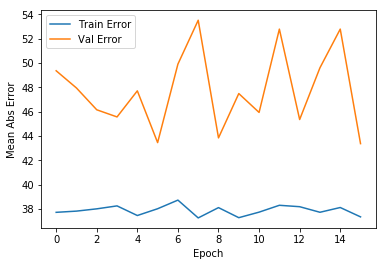

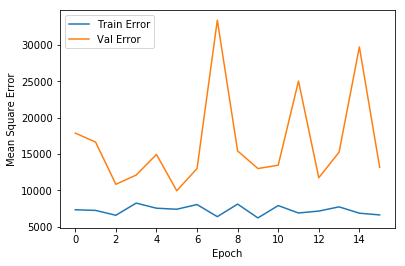

Mean squered error 11366.677728369426
RMSE 106.61462248851902


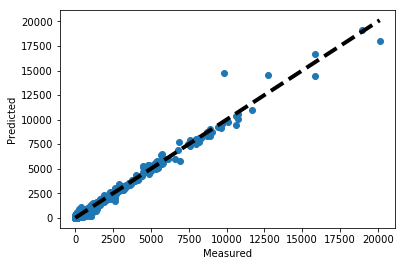

In [29]:
plot_history(history)
test_preds = model.predict(test_data)
plot_predictions(test_preds, test_targets)
print_score(test_preds, test_targets)

### HP tuning

In [31]:
regressor = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=make_model)
params = {
    "input_shape": [[len(feature_columns)]], 
    "layer_size": [16, 32, 64],
}

regressor_gs = GridSearchCV(
    estimator=regressor,
    param_grid=params,
    n_jobs=-1,
    cv=4,
    verbose=1,
)
regressor_gs.fit(train_data, train_targets)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.2s finished


Train on 28848 samples
28848/28848 [==============================] - 2s 62us/sample - loss: 318384.6384 - mean_squared_error: 318384.6875 - mean_absolute_error: 162.4627


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9c282b2c18>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'input_shape': [[6]], 'layer_size': [16, 32, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [32]:
test_pred = regressor_gs.best_estimator_.predict(test_data)

Mean squered error 11366.677728369426
RMSE 106.61462248851902


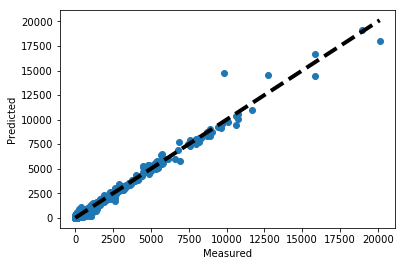

In [33]:
plot_predictions(test_preds, test_targets)
print_score(test_preds, test_targets)

In [41]:
def make_regressor(n_layers, layer_size, input_shape, learning_rate):
    layers = [tf.keras.layers.Dense(layer_size, activation='relu', input_shape=input_shape)]
    for _ in range(n_layers):
        layers.extend([
            tf.keras.layers.Dense(layer_size, activation='relu'),
        ]) 
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), 
        loss=tf.keras.losses.mean_squared_error, 
        metrics=[
            tf.keras.metrics.mean_squared_error,
            tf.keras.metrics.mae
        ]
    )
    return model

In [43]:
regressor = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=make_regressor)
params = {
    "n_layers":[2,8,16,32], 
    "layer_size":[16, 32],
    "input_shape": [[len(feature_columns)]], 
    "learning_rate": [1e-3],
}

regressor_gs = GridSearchCV(
    estimator=regressor,
    param_grid=params,
    n_jobs=-1,
    cv=4,
    verbose=1,
)
regressor_gs.fit(train_data, train_targets)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/skl

Train on 28848 samples
28848/28848 [==============================] - 4s 147us/sample - loss: 385337.4796 - mean_squared_error: 385337.5312 - mean_absolute_error: 179.0212


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9bed7af4e0>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_layers': [2, 8, 16, 32], 'layer_size': [16, 32], 'input_shape': [[6]], 'learning_rate': [0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [57]:
## Best model

In [58]:
best_model = make_regressor(n_layers=32, learning_rate=0.001, layer_size=32, input_shape=[6])

In [59]:
best_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 32)                224       
_________________________________________________________________
dense_107 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_108 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_109 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_110 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_111 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_112 (Dense)            (None, 32)               

In [60]:
history = best_model.fit(
    train_data,
    train_targets, 
    epochs=EPOCHS,
    validation_split=VAL_SPLIT,
    verbose=0,
    callbacks=[PrintDot()],
    batch_size=512,
    shuffle=True
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

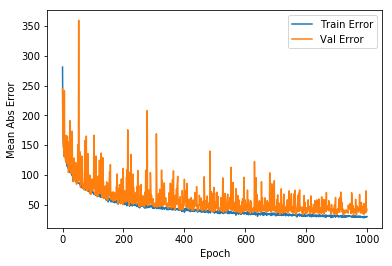

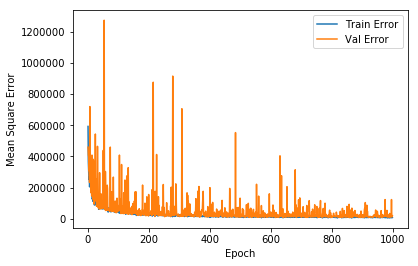

In [63]:
plot_history(history)

In [64]:
best_preds= best_model.predict(test_data)

Mean squered error 16241.196122177593
RMSE 127.44095151158278


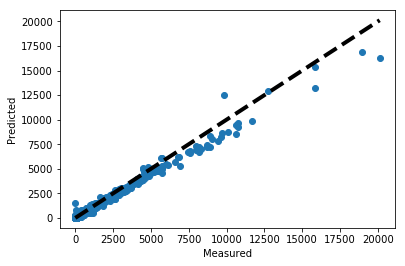

In [65]:
plot_predictions(best_preds, test_targets)
print_score(best_preds, test_targets)